# Beat-Upbeat Ratio Distributions

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.stats as stats
import statsmodels.formula.api as smf
from joblib import Parallel, delayed

import src.visualise.visualise_utils as vutils
from src import utils
from src.detect.onset_utils import OnsetMaker
from src.features.rhythm_features import BeatUpbeatRatio, get_beats_from_matched_onsets
from src.visualise.bur_plots import *

In [2]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
N_BOOT = 999

In [3]:
# Upper and lower bounds to use when thresholding BURs
BUR_UPPER = 4.0
BUR_LOWER = 0.25

In [4]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Load in data
We start by loading in our onset data. This gives us a list of `OnsetMaker` classes (defined in `src\detect\detect_utils.py`).

In [5]:
onsets: list[OnsetMaker] = utils.load_corpus_from_files(fr'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v02')

In [6]:
res = []
# Iterate through each track
for num, track in enumerate(onsets, 1):
    # Convert the summary dictionary (dictionary of arrays) to a dataframe
    summary_dict = pd.DataFrame(track.summary_dict)
    trio_tempo = (60 / get_beats_from_matched_onsets(track.summary_dict).diff()).mean()
    # Iterate through each instrument
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # Subset to get my onsets and partner onsets as separate dataframes
        my_onsets = track.ons[instr]
        my_beats = summary_dict[instr]
        # Extract BURs using our feature class
        bm = BeatUpbeatRatio(my_onsets=my_onsets, my_beats=my_beats, clean_outliers=False)
        # Iterate through every log BUR by that musician
        for bur in bm.bur_log['burs'].dropna().values:
            # Append a new dictionary
            res.append(dict(
                mbz_id=track.item['mbz_id'],
                in_30_corpus=track.item['in_30_corpus'],
                bur=bur,
                instrument=instr,
                tempo=trio_tempo,
                bandleader=track.item['bandleader'],
                year=track.item['recording_year']
            ))
burs = pd.DataFrame(res)

Before we do any cleaning, get the total number of beat-upbeat ratios

In [7]:
total_no_clean = burs.shape[0]
print(total_no_clean)

417278


## Clean data
We drop BUR values lower than 0.25 and higher than 4 (see Corcoran & Frieler, 2021)

In [8]:
burs = burs[(burs['bur'] > np.log2(BUR_LOWER)) & (burs['bur'] < np.log2(BUR_UPPER))]

Now we can get the total number of BURs after cleaning

In [9]:
total_after_clean = burs.shape[0]
print(total_after_clean)
print(1 - (total_after_clean / total_no_clean))

408506
0.02102195658529804


We can also get the number of BURs per instrument

In [10]:
burs.groupby('instrument')['bur'].count()

instrument
bass      47115
drums    209751
piano    151640
Name: bur, dtype: int64

In [11]:
burs.groupby('instrument')['bur'].mean().apply(np.exp)

instrument
bass     2.411334
drums    2.433485
piano    1.534158
Name: bur, dtype: float64

In [12]:
np.exp(burs['bur'].mean())

2.048312964628883

Here, we bootstrap confidence intervals for piano BURs

In [ ]:
means = []
pno = burs[burs['instrument'] == 'piano']
for state in range(vutils.N_BOOT):
    if state % 10 == 0:
        print(state)
    bls = pd.Series(pno['bandleader'].unique()).sample(frac=1, replace=True, random_state=state)
    means.append(pd.concat(pno[(pno['bandleader'] == bl)]['bur'] for bl in bls).mean())
print(np.percentile(means, 2.5), np.percentile(means, 97.5))

Now we order our dataframe so that the instruments are in the correct order (piano -> bass -> drums)

In [18]:
burs = (
    burs.set_index('instrument')
    .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
    .reset_index(drop=False)
)

## Compute the KDE and extract peaks

In [19]:
def get_peaks(data, len_data: int = 1000, **kwargs) -> np.ndarray:
    """Fits a kernel-density estimate to BUR data and extracts BUR peaks"""
    # Fit the actual KDE to the data, using the default parameters
    kde = stats.gaussian_kde(data.T, bw_method='silverman')
    # Create a linear space of integers ranging from our lowest to our highest BUR
    data_plot = np.linspace(data.min(), data.max(), len_data)[:, np.newaxis]
    # Evaluate the KDE on our linear space of integers
    kde_eval = kde.evaluate(data_plot.T)
    # Find the peaks from our fitted KDE
    peaks, _ = signal.find_peaks(kde_eval, **kwargs)
    # Return the sorted peaks from our KDE: this will be an array of BUR values
    return np.sort(data_plot[peaks].flatten())

In [20]:
def sort_bootstrap_peaks(bs_peaks, actual_peaks, tol: float = 0.5):
    boot_res = {peak: [] for peak in actual_peaks}
    for actual_peak in actual_peaks:
        distance = np.abs(np.unique(bs_peaks) - actual_peak)
        # Iterate through the peaks by minimum distance to actual peak
        for boot_peak in bs_peaks[np.argsort(distance)]:
            # If the distance to the peak is less than the tolerance
            if abs(boot_peak - actual_peak) <= 0.5:
                # We can return this bootstrapped peaks
                boot_res[actual_peak].append(boot_peak)
    return {k: [np.nanpercentile(v, 2.5), np.nanpercentile(v, 97.5)] for k, v in boot_res.items()}

In [21]:
def bootstrap_peaks(bl_sample, g):
    boot = np.concatenate([g[g['bandleader'] == bl]['bur'].values for bl in bl_sample])
    # Get the peaks for this bootstrapped sample
    return get_peaks(boot)

In [22]:
bandleaders = pd.Series(burs['bandleader'].unique())
bandleaders_samples = [bandleaders.sample(replace=True, frac=1, random_state=i).values for i in range(vutils.N_BOOT)]
res_ = []
for instr, grp in burs.groupby('instrument', sort=False):
    X = grp['bur'].to_numpy().reshape(-1, 1)
    grp_peaks = get_peaks(X)
    grp_peaks = np.array([i for i in grp_peaks if i > -1])
    with Parallel(n_jobs=-1, verbose=10) as par:
        boot_peaks = np.concatenate(par(delayed(bootstrap_peaks)(s, grp) for s in bandleaders_samples))
    ci_peaks = sort_bootstrap_peaks(boot_peaks, grp_peaks)
    for num, (actual, (low, high)) in enumerate(ci_peaks.items()):
        res_.append(dict(
            instrument=instr,
            peak_num=num,
            peak=actual,
            low=low,
            high=high
        ))

peaks_df = pd.DataFrame(res_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

In [23]:
peaks_df['exp'] = peaks_df['peak'].apply(np.exp)
print(peaks_df)

  instrument  peak_num      peak       low      high       exp
0      piano         0  0.366366  0.150150  0.434434  1.442484
1       bass         0  0.058058  0.030030  0.126126  1.059777
2       bass         1  1.227227  1.151151  1.269469  3.411756
3      drums         0 -0.910911 -1.149550 -0.701101  0.402158
4      drums         1  1.179179  1.131131  1.231231  3.251704


## Estimate density of distribution between peaks

In [ ]:
bandleaders = pd.Series(burs['bandleader'].unique())
bandleaders_sample = [bandleaders.sample(replace=True, frac=1) for i in range(1000)]
for instr, instr_peaks in zip(['bass'], [bass_peaks]):
    boot_low, boot_high = [], []
    for n, sample in enumerate(bandleaders_sample):
        print(n)
        data = []
        for _, bandleader in sample.items():
            data.extend(burs[(burs['bandleader'] == bandleader) & (burs['instrument'] == instr)]['bur'].to_list())
        low, high = estimate_density(instr_peaks, pd.Series(data),)
        boot_low.append(low)
        boot_high.append(high)
    print(instr, 'low_peak', stats.sem(boot_low) * 1.96)
    print(instr, 'high_peak', stats.sem(boot_high) * 1.96)

## Plot the BUR distribution with density curve and peaks

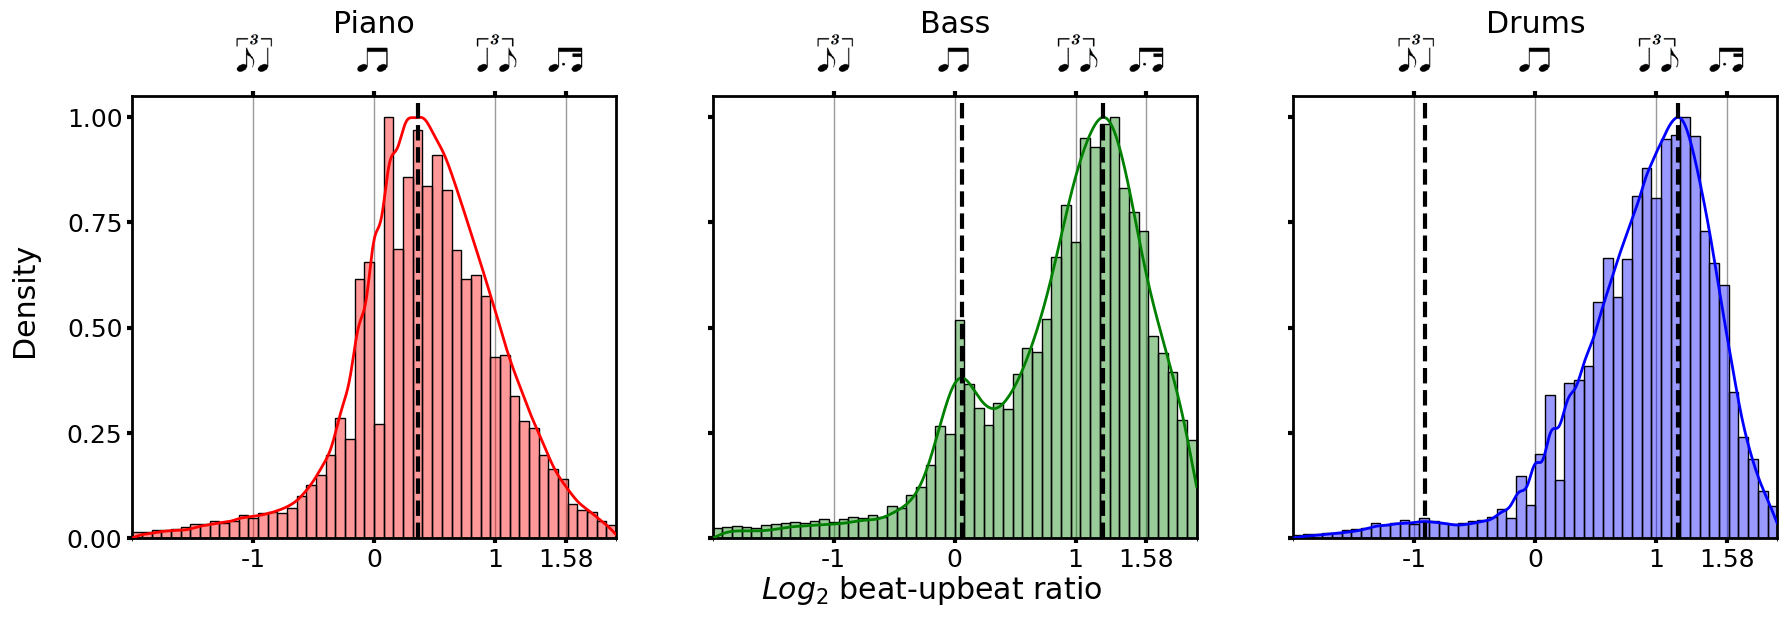

In [24]:
HistPlotBURByInstrument(burs, peaks_df).create_plot()
plt.show()

## Number of BURs < 0

In [25]:
len(burs[burs['bur'] >= 0]) / len(burs)

0.8861044880613749

In [15]:
for idx, grp in burs.groupby('instrument'):
    print(idx, round(len(grp[grp['bur'] >= 0]) / len(grp) * 100, 2))

bass 89.05
drums 93.39
piano 81.86


## Model average tempo vs BUR

In [26]:
grped = (
    burs.groupby(['instrument', 'mbz_id'])
    .agg(dict(bur=['mean', 'count'], tempo='median', bandleader='first', year='first'))
    .reset_index(drop=False)
)
grped.columns = ['_'.join(col).strip() for col in grped.columns.values]
grped = grped.rename(
    columns={'tempo_median': 'tempo', 'instrument_': 'instrument', 'bandleader_first': 'bandleader', 'year_first': 'year'}
)
grped['year'] = grped['year'].astype(int)

In [27]:
# Count tracks with fewer than 15 BURs
print(len(grped[grped['bur_count'] < 15]), len(grped))
print(grped[grped['bur_count'] < 15]['instrument'].value_counts())

471 3865
bass     401
drums     40
piano     30
Name: instrument, dtype: int64


In [28]:
# Remove these tracks
average = grped[grped['bur_count'] > 15]

In [29]:
average['tempo_standard'] = (average['tempo'] - average['tempo'].mean()) / average['tempo'].std()

/tmp/ipykernel_2642742/374506491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  average['tempo_standard'] = (average['tempo'] - average['tempo'].mean()) / average['tempo'].std()


In [30]:
md = smf.mixedlm(
    "bur_mean ~ tempo_standard * C(instrument, Treatment(reference='piano'))",
    data=average,
    groups=average['bandleader'],
    re_formula="0 + tempo_standard + C(instrument, Treatment(reference='piano'))"
).fit()
print(md.summary())

                                                         Mixed Linear Model Regression Results
Model:                                             MixedLM                                 Dependent Variable:                                 bur_mean
No. Observations:                                  3358                                    Method:                                             REML    
No. Groups:                                        29                                      Scale:                                              0.0567  
Min. group size:                                   14                                      Log-Likelihood:                                     -44.1133
Max. group size:                                   616                                     Converged:                                          No      
Mean group size:                                   115.8                                                                                         

In [31]:
(md.params['tempo_standard'] / average['tempo_standard'].std()) * 10

-1.39822976211719

In [32]:
# Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
var_fixed = md.predict().var()
# Variance explained by the random effects
var_random = float(md.cov_re.to_numpy().mean())
# Variance of the residuals
var_resid = md.scale
# Total variance of the model
total_var = var_fixed + var_random + var_resid
# Calculate the r2 values and append to the model
print('conditional_r2:', (var_fixed + var_random) / total_var)
print('marginal_r2:', var_fixed / total_var)

conditional_r2: 0.6186975346353593
marginal_r2: 0.5878753800112884


In [41]:
stddev = np.std([v.iloc[0] for v in md.random_effects.values()])
print('stdev of bandleader groups:', stddev)

stdev of bandleader groups: 0.11947812296031342


## Year vs swing

In [33]:
average['year_standard'] = (average['year'] - average['year'].mean()) / average['year'].std()

/tmp/ipykernel_2642742/3383312538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  average['year_standard'] = (average['year'] - average['year'].mean()) / average['year'].std()


In [34]:
md = smf.mixedlm(
    "bur_mean ~ tempo_standard * C(instrument, Treatment(reference='piano')) + year_standard + year_standard:tempo_standard",
    data=average,
    groups=average['bandleader'],
    re_formula="0 + tempo_standard + C(instrument, Treatment(reference='piano')) + year_standard"
).fit()
print(md.summary())

                                                         Mixed Linear Model Regression Results
Model:                                             MixedLM                                 Dependent Variable:                                 bur_mean
No. Observations:                                  3358                                    Method:                                             REML    
No. Groups:                                        29                                      Scale:                                              0.0545  
Min. group size:                                   14                                      Log-Likelihood:                                     -9.4692 
Max. group size:                                   616                                     Converged:                                          Yes     
Mean group size:                                   115.8                                                                                         

In [35]:
# Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
var_fixed = md.predict().var()
# Variance explained by the random effects
var_random = float(md.cov_re.to_numpy().mean())
# Variance of the residuals
var_resid = md.scale
# Total variance of the model
total_var = var_fixed + var_random + var_resid
# Calculate the r2 values and append to the model
print('conditional_r2:', (var_fixed + var_random) / total_var)
print('marginal_r2:', var_fixed / total_var)

conditional_r2: 0.6281132362176348
marginal_r2: 0.5933872307777472


## Plot average BUR vs tempo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 6002 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 7152 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 8402 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 9752 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

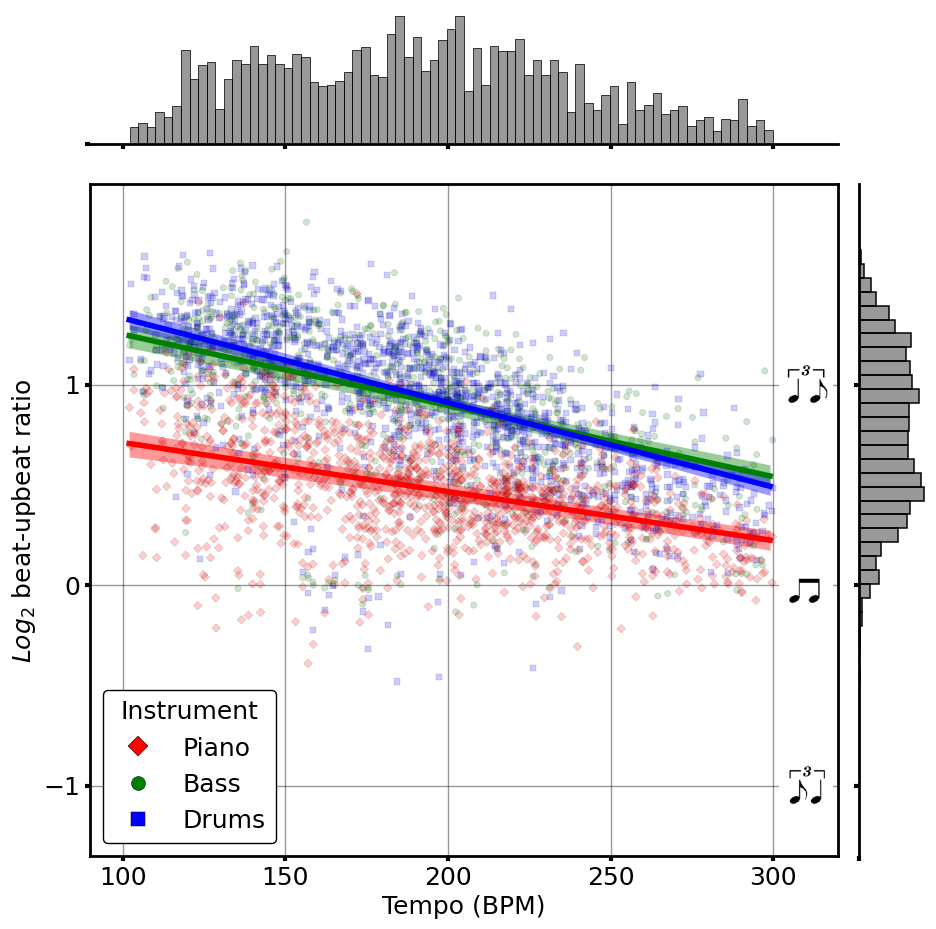

In [37]:
rp = RegPlotBURTempo(burs)
rp.N_BOOT = vutils.N_BOOT
rp.create_plot()
plt.show()

## Plot BUR distribution for JTD-300 pianists

In [13]:
jtd300 = burs[burs['in_30_corpus']]
jtd300['mbz_id'].nunique()

300

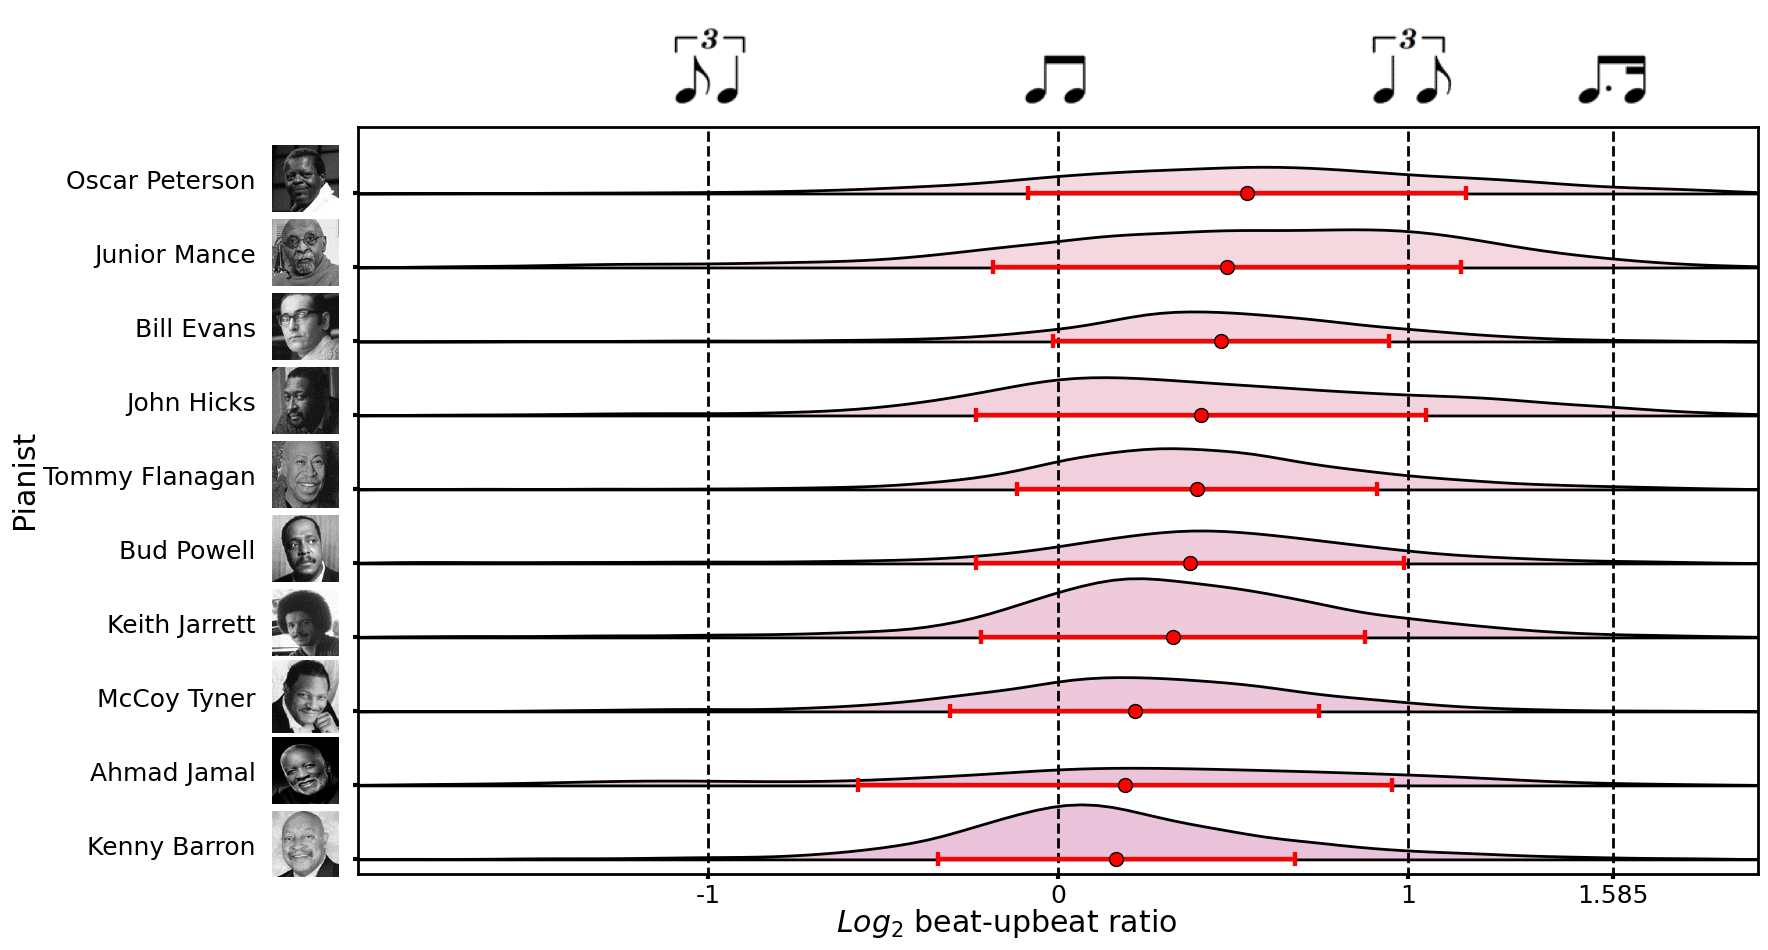

In [14]:
ViolinPlotBURs(jtd300).create_plot()
plt.show()

In [50]:
jtd300.groupby('bandleader')['bur'].describe()

,count,mean,std,min,25%,50%,75%,max
bandleader,,,,,,,,
Ahmad Jamal,6399.0,0.699904,0.790028,-1.966833,0.211504,0.862496,1.321928,2.0
Bill Evans,7350.0,0.722770,0.573346,-2.000000,0.387023,0.765535,1.152003,2.0
Bud Powell,8985.0,0.578873,0.618870,-2.000000,0.180572,0.637430,1.033947,2.0
John Hicks,13437.0,0.809543,0.627228,-2.000000,0.447459,0.925999,1.253757,2.0
Junior Mance,10880.0,0.818058,0.686787,-2.000000,0.447459,0.925999,1.321928,2.0
Keith Jarrett,17863.0,0.625205,0.641037,-2.000000,0.222392,0.637430,1.093109,2.0
Kenny Barron,17859.0,0.548641,0.664706,-2.000000,0.106915,0.547488,1.070389,2.0
McCoy Tyner,11077.0,0.532892,0.694888,-1.966833,0.125531,0.584963,1.058894,2.0
Oscar Peterson,7410.0,0.844555,0.663778,-1.959358,0.447459,1.000000,1.347923,2.0
